# Imitation Learning: Behavioural Cloning and the DAGGER Algorithm

# SOLUTIONS to 5.1


In this lesson you'll use imitation learning to teach a student policy to mimic an expert demonstrator! This is an important technique in robotics research.

We'll first try the behavioural cloning technique, which is a simple baseline for imitation learning. It can generate good policies, but they typically can't recover after making mistakes.

We'll then try the DAGGER algorithm, which results in policies that can recover from their mistakes!

You can then try the exercises at the end.


1. Setup
2. View the student and expert policies
3. Run Behavioural Cloning
4. Run the DAGGER algorithm
5. Exercises!

**This notebook doesn't need a GPU! You should be able to run it on a laptop CPU.**

## 1.1 Import the Necessary Packages

In [29]:
#add parent dir to find package. Only needed for source code build, pip install doesn't need it.
import os, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
os.sys.path.insert(0,parentdir)

import gym
import numpy as np
import pybullet_envs
import pybullet as p
import os.path
import time
import torch
torch.manual_seed(0)


## 1.2 Instantiate the Environment and Expert Demonstrator

We have two versions of the environment:

- `env_flagrun_with_rendering` which has a GUI for visualization
- `env_flagrun_without_rendering` which runs very quickly but doesn't show any visualization.

These will be useful later!

**If you ever get an error from the physics server, you'll have to run this cell again.**

In [30]:
from utils import rollout_for_one_episode as rollout_for_one_episode
from utils import rollout_for_n_episodes as rollout_for_n_episodes

# shutdown any physics clients that already exist
try: p.disconnect()
except: pass

# build the two versions of the environment
env_flagrun_harder_with_rendering = gym.make("HumanoidFlagrunHarderBulletEnv-v0")
env_flagrun_harder_with_rendering.render(mode="human")
env_flagrun_harder_without_rendering = gym.make("HumanoidFlagrunHarderBulletEnv-v0")


env_flagrun_with_rendering = gym.make("HumanoidFlagrunBulletEnv-v0")
env_flagrun_with_rendering.render(mode="human")
env_flagrun_without_rendering = gym.make("HumanoidFlagrunBulletEnv-v0")


# instantiate the expert
from flagrun_expert_demonstrator import *
flagrun_expert = ExpertPolicy(env_flagrun_with_rendering.observation_space,
                                    env_flagrun_with_rendering.action_space)
           

WalkerBase::__init__ start
WalkerBase::__init__ start
WalkerBase::__init__ start
WalkerBase::__init__ start


/Users/jamesough/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## 2.1 Watch the Untrained Student Policy

Our student policy is a two-layer neural net.

We'll use the first version of the environment, `env_flagrun_with_rendering`, which runs in real-time and creates a GUI for visualization.

Watch few rollouts in the GUI: the humanoid will fall to the floor because the policy hasn't been trained yet.

In [ ]:
# instantiate an untrained student policy
from model import StudentPolicy as StudentPolicy
student_policy = StudentPolicy(env_flagrun_with_rendering.observation_space,
                               env_flagrun_with_rendering.action_space)  


# view the untrained student policy (it should flop on the floor!)
rollout_data = rollout_for_n_episodes(n = 3,
                       policy = student_policy,
                       env = env_flagrun_with_rendering,
                       render=True)

## 2.2 Evaluate the Untrained Student Policy


Let's run the untrained student ten more times, recording the reward so that we have a baseline for later.

We'll use the second version of the environment, `env_flagrun_without_rendering`, which runs very quickly but doesn't show any visualization.

In [ ]:
rollout_data = rollout_for_n_episodes(n = 10,
                                      policy = student_policy,
                                      env = env_flagrun_without_rendering,
                                      render=False)

mean_student_score = np.mean(rollout_data['scores'])

print('Average Expert Score:', mean_student_score)

We ran the untrained student policy for 1000 iterations and recorded the scores so you can get a less-noisy idea of the score:

![](student_score_histogram.png)

## 2.3 Watch the Expert Demonstrator

Now we'll visualize the expert demonstrator!

You should be able to observe three distinct behaviours:

- Running towards a target
- Changing direction
- Getting up after a fall

You can click+drag on the expert to knock it over and see how it recovers.

Later, we'll train the student policy to imitate the expert.

CTRL+drag in the GUI to rotate the view. 


In [ ]:
flagrun_expert = ExpertPolicy(env_flagrun_with_rendering.observation_space,
                                    env_flagrun_with_rendering.action_space)
           
rollout_data = rollout_for_n_episodes(1,
                       flagrun_expert,
                       env = env_flagrun_with_rendering,
                       render=True)

## 2.4 Evaluate the Expert Demonstrator

Let's run the expert ten more times, recording the reward so that we have a baseline for later.

We'll use the second version of the environment, `env_flagrun_without_rendering`, which runs very quickly but doesn't show any visualization.

In [ ]:
rollout_data = rollout_for_n_episodes(n = 1000,
                                      policy = ExpertPolicy(env_flagrun_harder_without_rendering.observation_space,
                                      env_flagrun_without_rendering.action_space),
                                      env = env_flagrun_without_rendering,
                                      render=False)

mean_expert_score = np.mean(rollout_data['scores'])
std_expert_score = np.std(rollout_data['scores'])

print('Average Expert Score:', mean_expert_score, 'Standard Deviation in Expert Score:', std_expert_score)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(rollout_data['scores'], bins=50)
plt.title('Histogram of expert scores over 1000 epochs in the hard flagrun env')


We ran the untrained student policy for 1000 iterations so you get a less-noisy idea of the score:

![](expert_score_histogram.png)

We'll aim to hit an average score of about 500 with our student policy.

## 3.1 Train the Student Policy with Behavioural Cloning

In behavioural cloning, we run the expert policy and record all the *[state, action]* pairs. We then train a student policy (with supervised learning!) to directly imitate the expert's actions.

We've provided a helper function, `train_model`, which will train the student policy with the recorded expert *[state, action]* pairs.

In [ ]:
from utils import train_model as train_model
from utils import Dataset as Dataset

def behavioural_cloning(expert_policy, student_policy):
    '''
    Given an expert demonstrator and a student policy, perform
    n iterations of dagger.
    
    '''
    # collect initial expert demonstrations
    n=10
    print('Rolling Out Expert')
    expert_rollout_data = rollout_for_n_episodes(50,
                       expert_policy,
                       env = env_flagrun_harder_without_rendering,
                       render=False)
    
    # train student policy with supervised learning
    print('Training Student Model')
    student_policy = train_model(student_policy, expert_rollout_data, num_epochs = 500)
    return student_policy


student_policy = StudentPolicy(env_flagrun_with_rendering.observation_space,
                               env_flagrun_with_rendering.action_space)  

# Now run behavioural cloning
behavioural_cloning(flagrun_expert, student_policy)



## 3.2 Evaluate the Trained Student Policy

# My Solution

Text(0.5, 1.0, 'Histogram of behavioural-cloning student scores (in adversarial environment!) over 100 episodes')

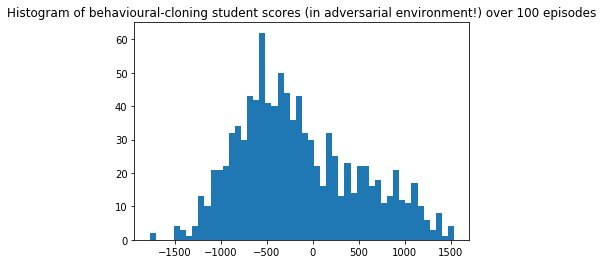

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(student_rollout_data['scores'], bins=50)
plt.title('Histogram of behavioural-cloning student scores (in adversarial environment!) over 100 episodes')

## 3.3 Watch the Trained Student Policy

Note that behavioural cloning works suprisingly well! The student policy should be able to run and turn. 

However if the student falls over, it can't get back up, because the expert doesn't fall enough to produce much training data!

The expert is too good to fail so the student never learns how to recover.

In [ ]:
student_rollout_data = rollout_for_n_episodes(n=1000,
                                            policy = student_policy,
                                            env = env_flagrun_without_rendering,
                                            render=False)

mean_student_score = np.mean(student_rollout_data['scores'])
std_student_score = np.std(student_rollout_data['scores'])
print('Average Expert Score:', mean_student_score, 'Standard Deviation in Expert Score:', std_student_score)

In [ ]:
rollout_for_n_episodes(n = 30,
                       policy = student_policy,
                       env = env_flagrun_with_rendering,
                       render=True)

# My solution

It works!

![](flagrun_adv_fallover.gif)_